In [7]:
# Import Neccessary Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the input and output sizes
input_size = 8  # sequence length
embedding_size = 32

# Create larger example data
inputs = torch.randint(1, 101, (100, input_size))  # random integers between 1 and 100
labels = torch.randint(0, 2, (100, ))  # binary labels

# Define a TensorDataset to hold the data
dataset = TensorDataset(inputs, labels)

# Define a DataLoader to iterate over the data in batches
batch_size = 10
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the ST2Vec model
class ST2Vec(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(ST2Vec, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=101, embedding_dim=embedding_size)  # use embedding layer to convert node IDs to dense vectors
        self.gc1 = nn.Linear(embedding_size, embedding_size)
        self.gc2 = nn.Linear(embedding_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, 2)  # classifier layer to output 2 classes

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.gc1(x))
        x = F.relu(self.gc2(x))
        x = x.mean(dim=1)  # average pooling over sequence dimension to generate final embedding
        x = self.classifier(x)  # classify the embeddings into 2 classes
        return x

# Instantiate an object of the ST2Vec class
model = ST2Vec(input_size, embedding_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Changed to CrossEntropyLoss for classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Variables for storing loss values for each epoch
train_loss = []
validation_loss = []

# Variables for storing true and predicted labels for ROC curve
true_labels = []
predicted_labels = []

# Split the data into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute the validation loss after each epoch
    with torch.no_grad():
        val_running_loss = 0.0
        for val_inputs, val_labels in validation_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            _, predicted = torch.max(val_outputs.data, 1)
            true_labels.extend(val_labels.tolist())
            predicted_labels.extend(predicted.tolist())

    train_loss.append(running_loss/len(train_loader))
    validation_loss.append(val_running_loss/len(validation_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_running_loss/len(validation_loader):.4f}")




Epoch [1/30], Training Loss: 0.7038, Validation Loss: 0.7246
Epoch [2/30], Training Loss: 0.6834, Validation Loss: 0.7189
Epoch [3/30], Training Loss: 0.6586, Validation Loss: 0.7708
Epoch [4/30], Training Loss: 0.6149, Validation Loss: 0.8152
Epoch [5/30], Training Loss: 0.5053, Validation Loss: 1.0944
Epoch [6/30], Training Loss: 0.3829, Validation Loss: 1.3974
Epoch [7/30], Training Loss: 0.2887, Validation Loss: 2.1831
Epoch [8/30], Training Loss: 0.2197, Validation Loss: 2.2720
Epoch [9/30], Training Loss: 0.1536, Validation Loss: 2.7105
Epoch [10/30], Training Loss: 0.1176, Validation Loss: 3.2501
Epoch [11/30], Training Loss: 0.0541, Validation Loss: 3.6000
Epoch [12/30], Training Loss: 0.0323, Validation Loss: 4.0873
Epoch [13/30], Training Loss: 0.0191, Validation Loss: 4.3662
Epoch [14/30], Training Loss: 0.0097, Validation Loss: 4.5019
Epoch [15/30], Training Loss: 0.0076, Validation Loss: 4.8062
Epoch [16/30], Training Loss: 0.0056, Validation Loss: 5.0388
Epoch [17/30], Tr

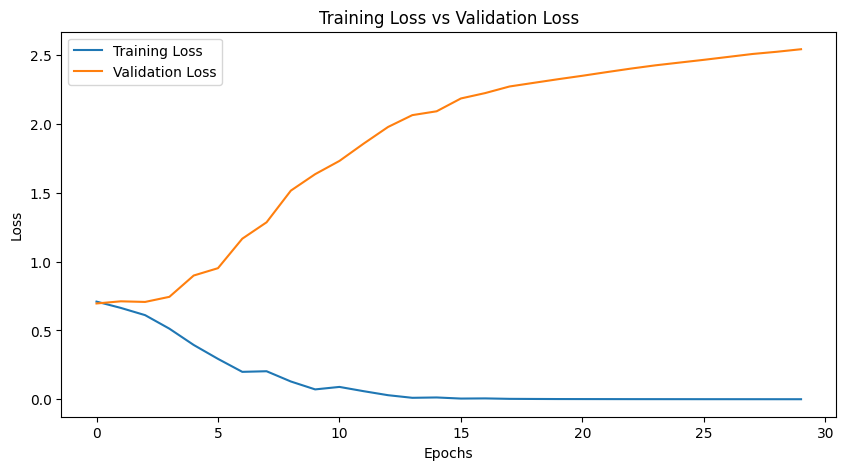

In [4]:
# Plotting Training Loss vs Validation Loss
plt.figure(figsize=(10, 5))
plt.title("Training Loss vs Validation Loss")
plt.plot(train_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

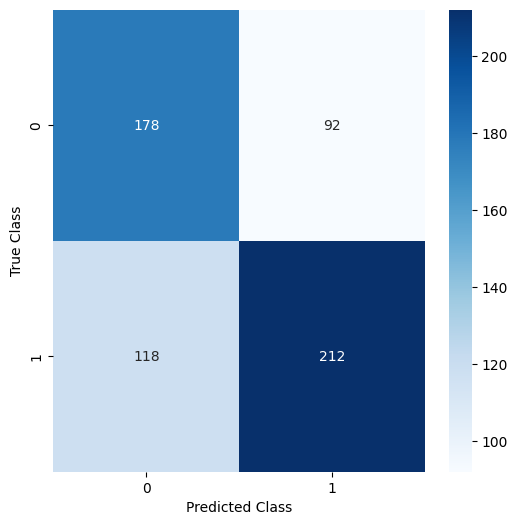

In [5]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

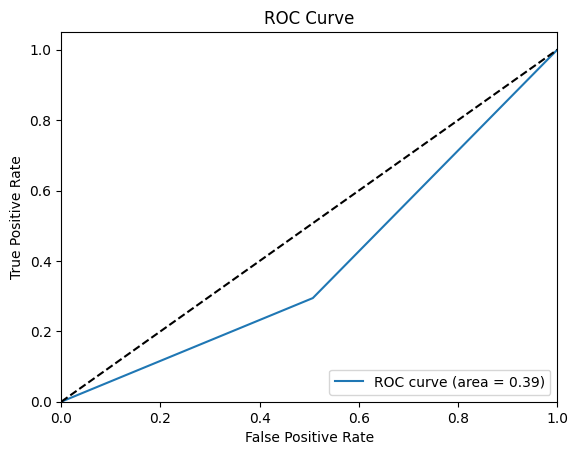

In [8]:
# ROC Curve and AUC
true_labels_bin = label_binarize(true_labels, classes=[0, 1])
predicted_labels_bin = label_binarize(predicted_labels, classes=[0, 1])
fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predicted_labels_bin.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

From what we can see the model is overfitting: Based on the provided training and validation losses, it seems like the model is overfitting. Here's why:

Training Loss is Decreasing: This is a good sign as it means our model is learning the training data better over each epoch.

Validation Loss is Increasing: Starting from epoch 2, the validation loss begins to increase and continues to do so for all subsequent epochs. This is a common sign of overfitting. It means that while our model is getting better at predicting the training data, it is getting worse at generalizing to new, unseen data (i.e., the validation data).

Overfitting often occurs when the model is too complex (i.e., too many layers or parameters) and/or there is not enough training data. The model learns the training data too well, including the noise and outliers, and therefore performs poorly on unseen data.

To mitigate overfitting, you could consider some of the following strategies:

Collect more training data, if possible.
Implement dropout, which randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting.
Use weight regularization (L1 or L2), which add a cost to the loss function for large weights.
Stop the training early, as soon as the validation loss starts to increase (early stopping).
Try simpler model architectures.
Data augmentation can also sometimes be beneficial.